In [1]:
#%matplotlib inline
%pylab inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import pandas as pd
import dask.dataframe as dd
import dask.array as da

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import alpha, beta, cp_t_exact, sigma0

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cosima_cookbook as cc
session = cc.database.create_session()

### Conservation Equation for PV

The conservation equation for PV is given by:

\begin{equation}
    \frac{\partial}{\partial t} \Big( \rho Q \Big) + \nabla \cdot \textbf(J) = 0
\end{equation}
where Q is defined by Marshall and Nurser(1992) as:
\begin{equation}
    Q = -\frac{\xi \cdot \nabla \sigma}{\rho}
\end{equation}

where $\xi$ is the absolute vorticity, equal to the sum of relative and planetary vorticity.

This notebook evaluates J using the following relation:
\begin{equation}
    \textbf{J} = \omega \frac{\partial \sigma}{\partial t} + \frac{\partial \textbf{u}}{\partial t} \times \nabla \sigma + \nabla B \times \nabla \sigma
\end{equation}

In [3]:
expt = '01deg_jra55v13_ryf9091'
vars_01deg = cc.querying.get_variables(session, experiment='01deg_jra55v13_ryf9091')
vars_01deg[vars_01deg['name'].str.lower().str.match('eta')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
80,eta_t,surface height on T cells [Boussinesq (volume ...,1 daily,output953/ocean/ocean_daily.nc,757,1950-01-01 00:00:00,2139-07-01 00:00:00
142,eta_global,global ave eta_t plus patm_t/(g*rho0),1 monthly,output953/ocean/ocean_scalar.nc,954,1900-01-01 00:00:00,2139-07-01 00:00:00


In [4]:
expt = '01deg_jra55v13_ryf9091'
start_time = '2088-12-01'
end_time = '2088-12-31'

x_u = cc.querying.getvar(expt,'xu_ocean',session,n=1).sel(xu_ocean=slice(-90,10))
x_t = cc.querying.getvar(expt,'xt_ocean',session,n=1).sel(xt_ocean=slice(-90,10))
y_u = cc.querying.getvar(expt,'yu_ocean',session,n=1).sel(yu_ocean=slice(10,65))
y_t = cc.querying.getvar(expt,'yt_ocean',session,n=1).sel(yt_ocean=slice(10,65))
z_t = cc.querying.getvar(expt,'st_ocean',session,n=1)

r0 = 6.371 * 10**6
av = 7.2921159 * 10**(-5)
rho_0 = 1026
g = 9.81
f = 2*av*np.sin((y_t*np.pi)/180)  #Coriolis Parameter

In [5]:
u = cc.querying.getvar(expt,'u',session,ncfile ='ocean_daily_3d_u_12.nc',start_time='2088-12-01',
                          end_time='2088-12-31').sel(xu_ocean=slice(-90,10)).sel(yu_ocean=slice(10,65))
u = u.sel(time=slice(start_time,end_time))
v = cc.querying.getvar(expt,'v',session,ncfile ='ocean_daily_3d_v_12.nc',start_time='2088-12-01',
                          end_time='2088-12-31').sel(xu_ocean=slice(-90,10)).sel(yu_ocean=slice(10,65))
v = v.sel(time=slice(start_time,end_time))
salt = cc.querying.getvar(expt,'salt',session,ncfile ='ocean_daily_3d_salt_12.nc',start_time='2088-12-01',
                          end_time='2088-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
salt = salt.sel(time=slice(start_time,end_time))
T = cc.querying.getvar(expt,'temp',session,ncfile='ocean_daily_3d_temp_12.nc',start_time='2088-12-01',
                       end_time='2088-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
T = T.sel(time=slice(start_time,end_time))
wt = cc.querying.getvar(expt,'wt',session,ncfile ='ocean_daily_3d_wt_12.nc',start_time='2088-12-01',
                          end_time='2088-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
wt = wt.sel(time=slice(start_time,end_time))
eta = cc.querying.getvar(expt,'eta_t',session,ncfile ='ocean_daily.nc',start_time='2088-12-01',
                          end_time='2088-12-31').sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
eta = eta.sel(time=slice(start_time,end_time))

In [6]:
import xgcm

u = u.rename('Velocity in x direction')
v = v.rename('Velocity in y direction')
paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091_gadi_retest/output328/ocean/ocean.nc")
data = xr.merge((u,v,T,wt))
data.coords['xt_ocean'].attrs.update(axis='X')
data.coords['xu_ocean'].attrs.update(axis='X',c_grid_axis_shift = 0.5)
#data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['yt_ocean'].attrs.update(axis='Y')
data.coords['yu_ocean'].attrs.update(axis='Y',c_grid_axis_shift = 0.5)
data.coords['st_ocean'].attrs.update(axis='Z')
data.coords['sw_ocean'].attrs.update(axis='Z',c_grid_axis_shift = 0.5)
#data.coords['yu_ocean'].attrs.update(axis='Y')
#data.coords['st_ocean'].attrs.update(axis='Z')

temp = xgcm.Grid(data, periodic=['X'])
tempo = temp.interp(u,'X')
u_itp = temp.interp(tempo,'Y',boundary="extend")

temp = xgcm.Grid(data, periodic=['Y'])
tempo = temp.interp(v,'Y')
v_itp = temp.interp(tempo,'X',boundary="extend")

temp = xgcm.Grid(data, periodic=['Z'])
wt_itp = temp.interp(wt,'Z')

u_itp = u_itp.rename('Interpolated velocity in x direction')
v_itp = v_itp.rename('Interpolated velocity in y direction')
wt_itp = wt_itp.rename('Interpolated velocity in z direction')

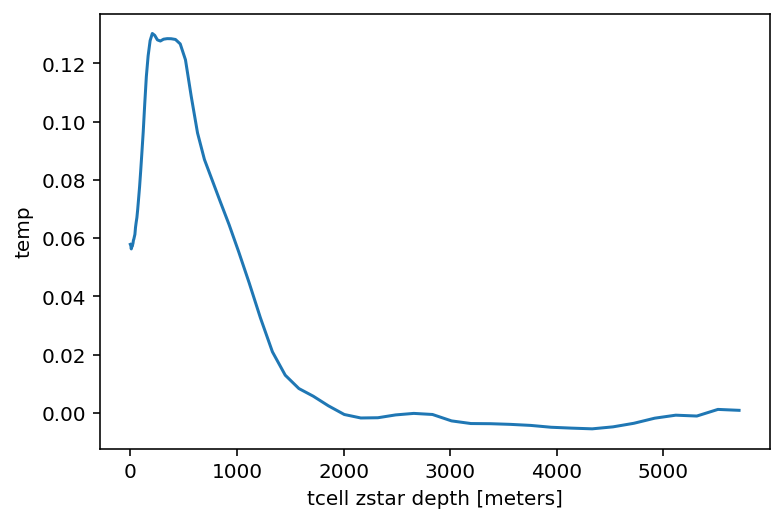

In [7]:
T.differentiate('xt_ocean').mean('xt_ocean').mean('yt_ocean').mean('time').plot()

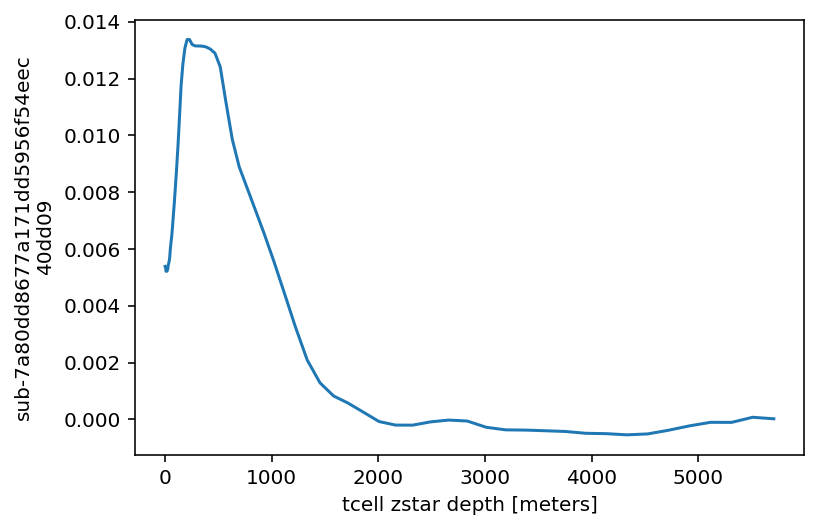

In [8]:
grid = xgcm.Grid(data, periodic=['X'])
grid.diff(data.temp,'X').mean('time').mean('xu_ocean').mean('yt_ocean').plot()

In [9]:
potrho = sigma0(salt,T-273.15)
potrho = potrho.chunk((31,7,300,400))
Gradt_potrho = potrho.differentiate('time')
Gradx_potrho = potrho.differentiate('xt_ocean')*(180/np.pi)/(r0*np.cos((potrho.yt_ocean*np.pi)/180))
Grady_potrho = potrho.differentiate('yt_ocean')*(180/np.pi)/r0
#Gradz_potrho = potrho.differentiate('st_ocean')
Gradz_potrho = -potrho.differentiate('st_ocean')

In [10]:
u_itp = u_itp.chunk((31,7,300,400))
v_itp = v_itp.chunk((31,7,300,400))
wt_itp = wt_itp.chunk((31,7,300,400))
wt_itp = wt_itp.fillna(0)
Gradt_u = u_itp.differentiate('time')
Gradt_v = v_itp.differentiate('time')
Gradt_wt = wt_itp.differentiate('time')

In [11]:
#Absolute vorticity
#vrt_x = (1/r0)*((r0*v_itp).differentiate('st_ocean') - wt_itp.differentiate('yt_ocean'))
vrt_x = (1/r0)*((-r0*v_itp).differentiate('st_ocean') + wt_itp.differentiate('yt_ocean'))
#vrt_y = (1/r0)*((1/(np.cos(potrho.yt_ocean*np.pi)/180))*(wt_itp.differentiate(
#    'xt_ocean')) - (r0*u_itp).differentiate('st_ocean'))
vrt_y = -(1/r0)*((1/(np.cos(potrho.yt_ocean*np.pi)/180))*(wt_itp.differentiate(
    'xt_ocean')) + (r0*u_itp).differentiate('st_ocean'))
#vrt_z = (1/(r0*np.cos((potrho.yt_ocean*np.pi)/180)))*((u_itp*np.cos(potrho.yt_ocean*np.pi)/180).differentiate(
#    'yt_ocean') - v_itp.differentiate('xt_ocean')) + f
vrt_z = (1/(r0*np.cos((potrho.yt_ocean*np.pi)/180)))*((-u_itp*np.cos(potrho.yt_ocean*np.pi)/180).differentiate(
    'yt_ocean') - v_itp.differentiate('xt_ocean')) + f

In [12]:
Y,Z,X =  np.meshgrid(y_t,z_t,x_t)
pressure_array = xr.DataArray(p_from_z(-Z,Y),  coords = [z_t, y_t, x_t],  
                              dims=['st_ocean','yt_ocean','xt_ocean'],name='pressure', attrs = {'units':'dbar'})
pressure_array_NA = pressure_array.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(10,65))
rho_mat = rho(salt,T-273.15,pressure_array_NA)

In [13]:
ertel_PV = -(1/rho_mat)*(vrt_x*Gradx_potrho + vrt_y*Grady_potrho + vrt_z*Gradz_potrho)

In [14]:
#Calculating gradient of Bernoulli function
u_itp_sq = u_itp**2
v_itp_sq = v_itp**2
B = (1/rho_mat)*(pressure_array_NA + rho_mat*g*eta) + u_itp_sq/2 + v_itp_sq/2
Gradx_B = B.differentiate('xt_ocean')*(180/np.pi)/(r0*np.cos((potrho.yt_ocean*np.pi)/180))
Grady_B = B.differentiate('yt_ocean')*(180/np.pi)/r0
#Gradz_B = B.differentiate('st_ocean')
Gradz_B = -B.differentiate('st_ocean')

In [15]:
J_z = Gradt_potrho*vrt_z + (Gradx_B*Grady_potrho - Grady_B*Gradx_potrho) + (
    Gradt_u*Grady_potrho - Gradt_v*Gradx_potrho)
J_y = Gradt_potrho*vrt_y + (Gradz_B*Gradx_potrho - Gradx_B*Gradz_potrho) + (
    Gradt_wt*Gradx_potrho - Gradt_u*Gradz_potrho)
J_x = Gradt_potrho*vrt_x + (Grady_B*Gradz_potrho - Gradz_B*Grady_potrho) + (
    Gradt_v*Gradz_potrho - Gradt_wt*Grady_potrho)
#Gradz_J_z = 1/(r0**2)*(r0**2*J_z).differentiate('st_ocean')
Gradz_J_z = (-1/(r0**2))*(r0**2*J_z).differentiate('st_ocean')
#Grady_J_y = (1/r0*np.cos((potrho.yt_ocean*np.pi)/180))*(J_y*np.cos((
#    potrho.yt_ocean*np.pi)/180)).differentiate('yt_ocean')*(180/np.pi)/r0
Grady_J_y = -(1/r0*np.cos((potrho.yt_ocean*np.pi)/180))*(J_y*np.cos((
    potrho.yt_ocean*np.pi)/180)).differentiate('yt_ocean')*(180/np.pi)/r0
Gradx_J_x = (1/r0*np.cos((potrho.yt_ocean*np.pi)/180))*J_x.differentiate('xt_ocean')*(180/np.pi)/(r0*np.cos((potrho.yt_ocean*np.pi)/180))
div_J = Gradx_J_x + Grady_J_y + Gradz_J_z

In [16]:
ertel_PV = ertel_PV.chunk((31,7,300,400))
rho_mat = rho_mat.chunk((31,7,300,400))
LHS = (rho_mat*ertel_PV).differentiate('time')

In [17]:
div_J_val = div_J.mean('xt_ocean').mean('yt_ocean').sel(st_ocean = 1,method = 'nearest').values
LHS_val = LHS.mean('xt_ocean').mean('yt_ocean').sel(st_ocean = 1,method = 'nearest').values

In [18]:
time = np.linspace(1,31,31)

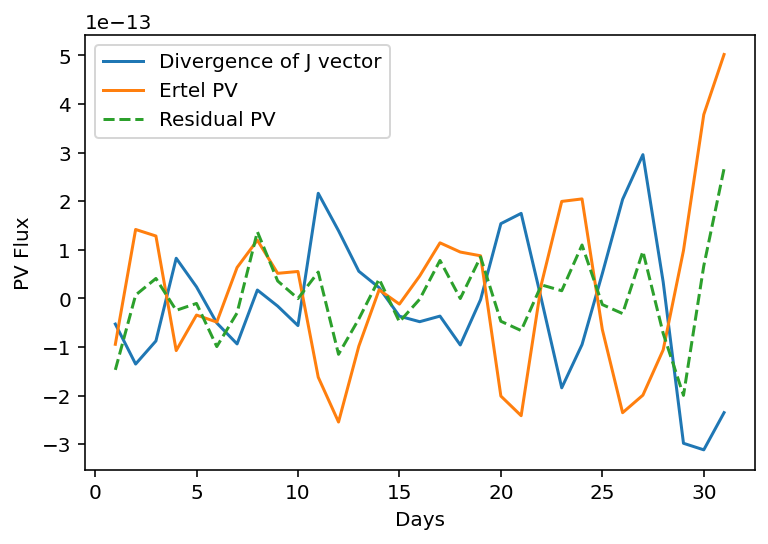

In [19]:
plt.plot(time,div_J_val,label = 'Divergence of J vector')
plt.plot(time,LHS_val,label = 'Ertel PV')
plt.plot(time,div_J_val + LHS_val,linestyle='dashed',label = 'Residual PV')
plt.ylabel('PV Flux')
plt.xlabel('Days')
plt.legend()
plt.show()

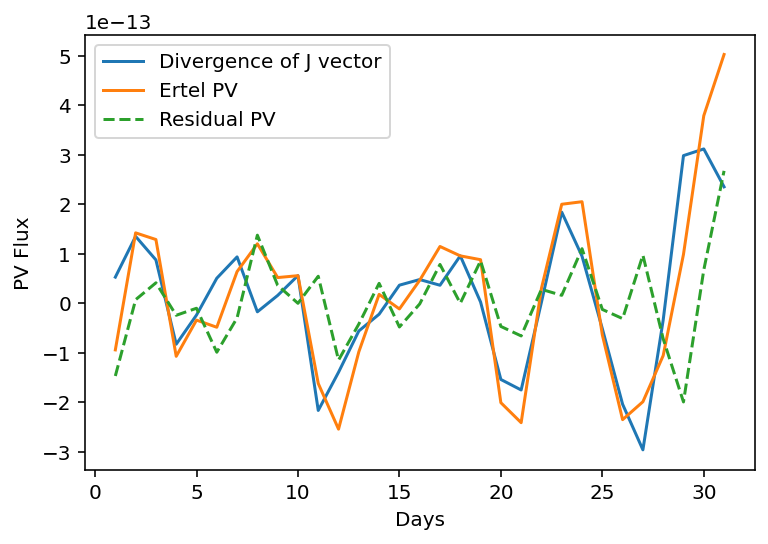

In [21]:
plt.plot(time,-div_J_val,label = 'Divergence of J vector')
plt.plot(time,LHS_val,label = 'Ertel PV')
plt.plot(time,div_J_val + LHS_val,linestyle='dashed',label = 'Residual PV')
plt.ylabel('PV Flux')
plt.xlabel('Days')
plt.legend()
plt.show()

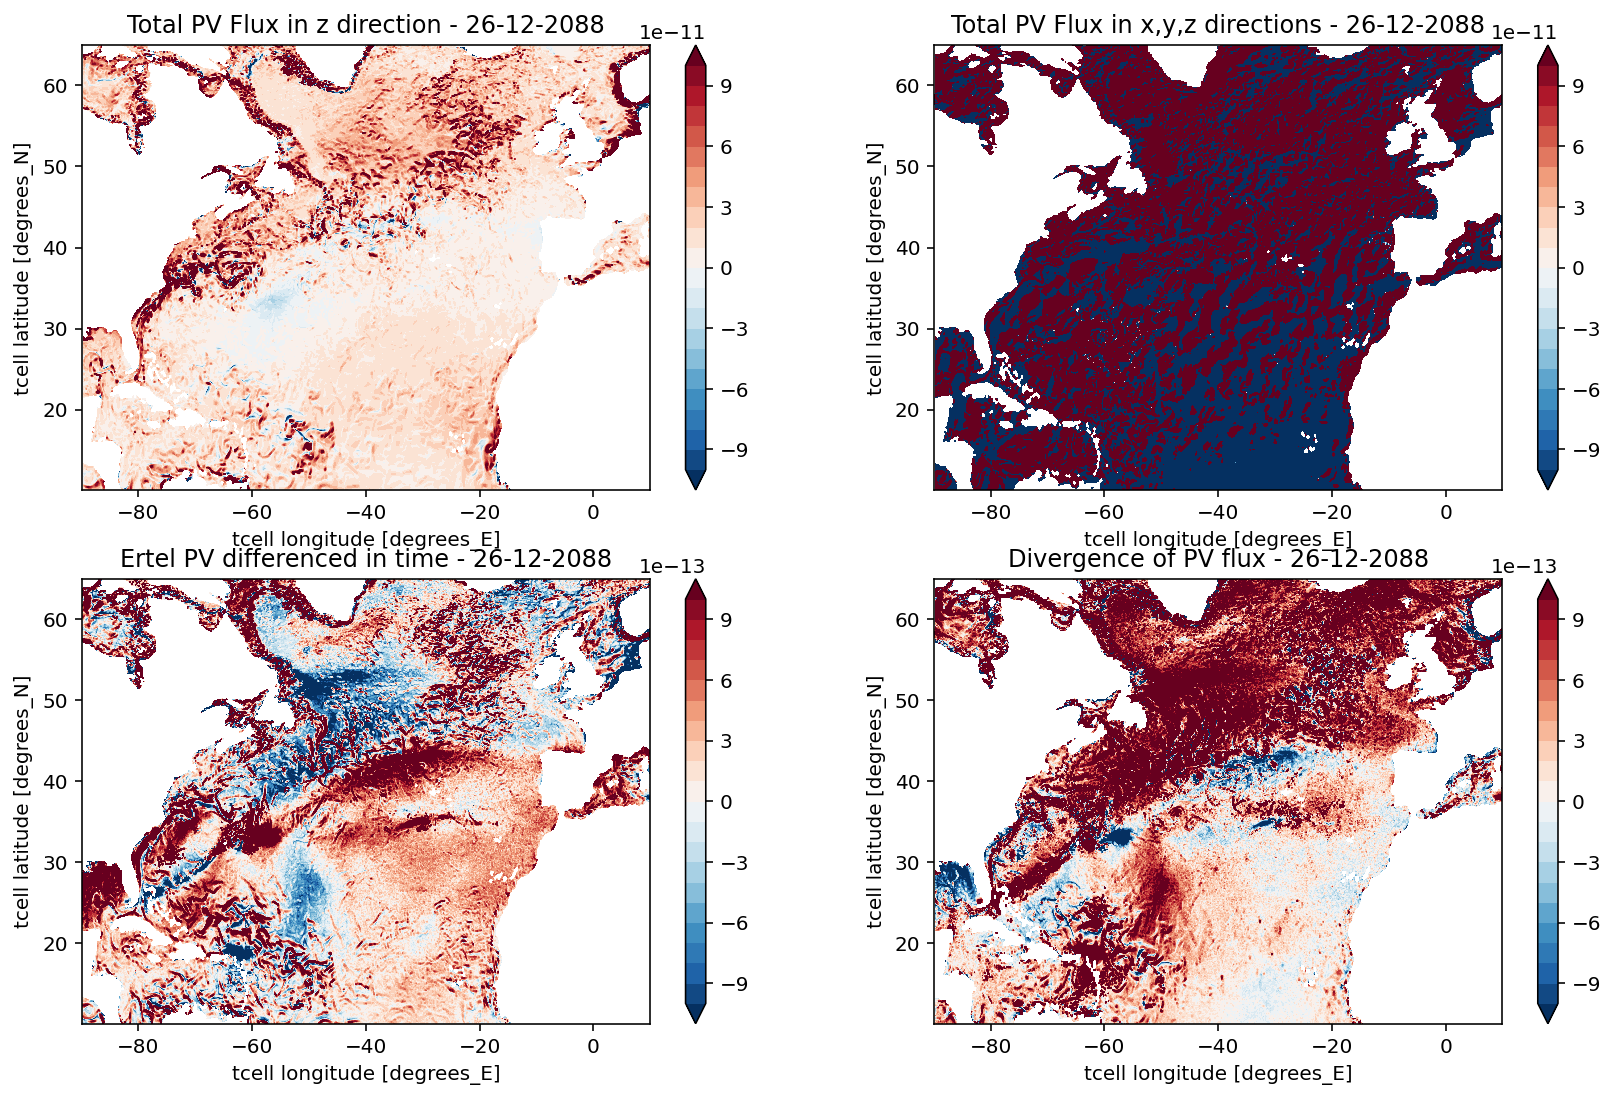

In [20]:
plt.figure(figsize=(14,9))

plt.subplot(221)
J_total = J_z.sel(time=slice('2088-12-26', '2088-12-26')).sel(st_ocean = 1, method = 'nearest')
J_total.mean('time').plot.contourf(levels = np.linspace(-1e-10,1e-10,21))
plt.title("Total PV Flux in z direction - 26-12-2088")

plt.subplot(222)
Jzf_summer = (J_x + J_y + J_z).sel(time=slice('2088-12-26', '2088-12-26')).sel(st_ocean = 1, method = 'nearest')
Jzf_summer.mean('time').plot.contourf(levels = np.linspace(-1e-10,1e-10,21))
plt.title("Total PV Flux in x,y,z directions - 26-12-2088")

plt.subplot(223)
LHS_26 = LHS.sel(time=slice('2088-12-26', '2088-12-26')).sel(st_ocean = 1, method = 'nearest')
LHS_26.mean('time').plot.contourf(levels = np.linspace(-1e-12,1e-12,21))
plt.title("Ertel PV differenced in time - 26-12-2088")

plt.subplot(224)
RHS_26 = div_J.sel(time=slice('2088-12-26', '2088-12-26')).sel(st_ocean = 1, method = 'nearest')
RHS_26.mean('time').plot.contourf(levels = np.linspace(-1e-12,1e-12,21))
plt.title("Divergence of PV flux - 26-12-2088")

plt.show()